In [5]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import grad, Variable
import autograd
import autograd.numpy as np
import copy
import scipy as sp
from scipy import stats
from sklearn import metrics
import sys
import ot
import gwot
from gwot import models, sim, ts, util
import gwot.bridgesampling as bs
import dcor

sys.path.append("fig1_batch/")
import importlib
import models
importlib.reload(models)
import random
import model_fig1 as model_sim

In [6]:
import os
num_threads = "8"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads
torch.set_num_threads(8)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [8]:
PLT_CELL = 2.5

In [9]:
# set random seed
SRAND = 0
torch.manual_seed(SRAND)
np.random.seed(SRAND)

In [10]:
M = 100
N = 64
sim = gwot.sim.Simulation(V = model_sim.Psi, dV = model_sim.dPsi, birth_death = False, 
                          N = np.full(model_sim.T, N),
                          T = model_sim.T, 
                          d = model_sim.dim, 
                          D = model_sim.D, 
                          t_final = model_sim.t_final, 
                          ic_func = model_sim.ic_func, 
                          pool = None)
sim.sample(steps_scale = int(model_sim.sim_steps/sim.T));

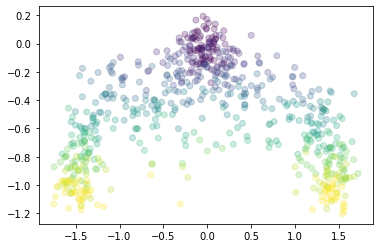

In [11]:
plt.scatter(sim.x[:, 0], sim.x[:, 1], alpha = 0.25, c = sim.t_idx)

In [12]:
importlib.reload(models)

<module 'models' from '/zfs/users/syz/syz/mfl/models.py'>

In [13]:
model = models.TrajLoss(torch.randn(model_sim.T, M, model_sim.dim)*1.0,
                        torch.tensor(sim.x, device = device), 
                        torch.tensor(sim.t_idx, device = device), 
                        dt = model_sim.t_final/model_sim.T, tau = model_sim.D, sigma = None, M = M,
                        lamda_reg = 0.05, lamda_cst = 1.0, sigma_cst = 5.0,
                        branching_rate_fn = model_sim.branching_rate,
                        sinkhorn_iters = 250, device = device, warm_start = True)

In [14]:
output = models.optimize(model, n_iter = 2500, eta_final = 0.25, tau_final = model_sim.D, sigma_final = 0.5, temp_init = 1.0, temp_ratio = 1.0, N = M, dim = model_sim.dim, tloss = model, print_interval = 50)

Iteration 0, Loss = 22.160, Primal loss = 21.328, Avg. iters = 249.000, eta = 0.250, temp = 1.000
Iteration 50, Loss = 2.907, Primal loss = 2.829, Avg. iters = 112.444, eta = 0.250, temp = 1.000
Iteration 100, Loss = 2.306, Primal loss = 2.510, Avg. iters = 96.222, eta = 0.250, temp = 1.000
Iteration 150, Loss = 2.008, Primal loss = 2.381, Avg. iters = 85.444, eta = 0.250, temp = 1.000
Iteration 200, Loss = 1.786, Primal loss = 2.323, Avg. iters = 108.778, eta = 0.250, temp = 1.000
Iteration 250, Loss = 1.650, Primal loss = 2.292, Avg. iters = 102.222, eta = 0.250, temp = 1.000
Iteration 300, Loss = 1.585, Primal loss = 2.281, Avg. iters = 106.778, eta = 0.250, temp = 1.000
Iteration 350, Loss = 1.504, Primal loss = 2.279, Avg. iters = 108.889, eta = 0.250, temp = 1.000
Iteration 400, Loss = 1.412, Primal loss = 2.256, Avg. iters = 98.556, eta = 0.250, temp = 1.000
Iteration 450, Loss = 1.314, Primal loss = 2.253, Avg. iters = 74.556, eta = 0.250, temp = 1.000
Iteration 500, Loss = 1.2

In [15]:
importlib.reload(models)

<module 'models' from '/zfs/users/syz/syz/mfl/models.py'>

In [16]:
model_anneal = models.TrajLoss(torch.randn(model_sim.T, M, model_sim.dim)*1.0,
                        torch.tensor(sim.x, device = device), 
                        torch.tensor(sim.t_idx, device = device), 
                        dt = model_sim.t_final/model_sim.T, tau = model_sim.D, sigma = None, M = M,
                        lamda_reg = 0.05, lamda_cst = 1.0, sigma_cst = 5.0,
                        branching_rate_fn = model_sim.branching_rate,
                        sinkhorn_iters = 250, device = device, warm_start = True)

output_anneal = models.optimize(model_anneal, n_iter = 2500, eta_final = 0.25, tau_final = model_sim.D, sigma_final = 0.5, temp_init = 5, temp_ratio = (1/5)**(1/500), N = M, dim = model_sim.dim, tloss = model_anneal, print_interval = 50)

Iteration 0, Loss = 13.411, Primal loss = 8.848, Avg. iters = 139.333, eta = 1.250, temp = 5.000
Iteration 50, Loss = 1.179, Primal loss = 1.596, Avg. iters = 23.111, eta = 1.064, temp = 4.257
Iteration 100, Loss = 0.982, Primal loss = 1.853, Avg. iters = 21.000, eta = 0.906, temp = 3.624
Iteration 150, Loss = 0.770, Primal loss = 2.046, Avg. iters = 20.778, eta = 0.771, temp = 3.085
Iteration 200, Loss = 0.756, Primal loss = 2.208, Avg. iters = 25.333, eta = 0.657, temp = 2.627
Iteration 250, Loss = 0.713, Primal loss = 2.275, Avg. iters = 27.667, eta = 0.559, temp = 2.236
Iteration 300, Loss = 0.739, Primal loss = 2.357, Avg. iters = 23.333, eta = 0.476, temp = 1.904
Iteration 350, Loss = 0.681, Primal loss = 2.382, Avg. iters = 12.889, eta = 0.405, temp = 1.621
Iteration 400, Loss = 0.743, Primal loss = 2.378, Avg. iters = 10.667, eta = 0.345, temp = 1.380
Iteration 450, Loss = 0.763, Primal loss = 2.370, Avg. iters = 7.556, eta = 0.294, temp = 1.175
Iteration 500, Loss = 0.811, Pri

In [17]:
output_anneal[2][0].shape

torch.Size([10, 100, 10])

In [18]:
import tqdm
from tqdm import tqdm
primal_anneal = []

for i in tqdm(range(len(output_anneal[2]))):
    model_tmp = models.TrajLoss(output_anneal[2][i],
                            torch.tensor(sim.x, device = device), 
                            torch.tensor(sim.t_idx, device = device), 
                            dt = model_sim.t_final/model_sim.T, tau = model_sim.D, sigma = 0.5, M = M,
                            lamda_reg = 0.05, lamda_cst = 1.0, sigma_cst = 5.0,
                            branching_rate_fn = model_sim.branching_rate,
                            sinkhorn_iters = 1_000, device = device, warm_start = True)
    model_tmp.forward()
    with torch.no_grad():
        primal_anneal.append(model_tmp.forward_primal().item() + model_tmp.tau*model_tmp.lamda_reg*sum([models.entropy_est_knn(model_tmp.x[i, :, :], d = model_tmp.d, k = 2) for i in range(model_tmp.x.shape[0])]))

100%|██████████| 2500/2500 [02:56<00:00, 14.14it/s]


In [19]:
err = [np.mean([dcor.energy_distance(x, y) for (x, y) in zip(output[2][i], output[2][-1])]) for i in range(len(output[2])-1)]
err_anneal = [np.mean([dcor.energy_distance(x, y) for (x, y) in zip(output_anneal[2][i], output_anneal[2][-1])]) for i in range(len(output_anneal[2])-1)]

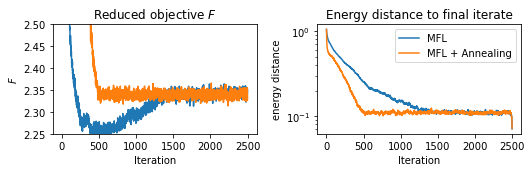

In [20]:
plt.figure(figsize = (3*PLT_CELL, PLT_CELL))
plt.subplot(1, 2, 1)
plt.plot(output[1], label = "MFL")
# plt.plot(output_anneal[1], label = "MFL + Annealing")
plt.plot(primal_anneal, label = "MFL + Annealing")
plt.ylim(2.25, 2.5)
plt.title("Reduced objective $F$")
plt.xlabel("Iteration")
plt.ylabel("$F$")
plt.subplot(1, 2, 2)
plt.plot(np.sqrt(np.array(err)), label = "MFL")
plt.plot(np.sqrt(np.array(err_anneal)), label = "MFL + Annealing")
plt.title("Energy distance to final iterate")
plt.xlabel("Iteration")
plt.ylabel("energy distance")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.savefig("appendix_annealing_a.pdf")

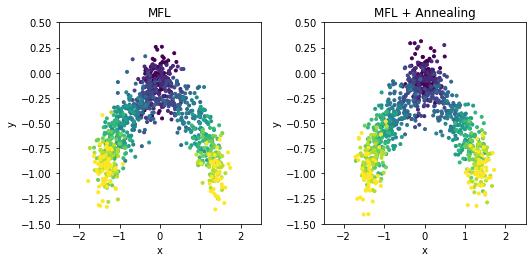

In [21]:
plt.figure(figsize = (3*PLT_CELL, 3/2*PLT_CELL))
plt.subplot(1, 2, 1)
with torch.no_grad():
    plt.scatter(model.x.reshape(-1, model_sim.dim)[:, 0], model.x.reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.arange(model_sim.T), np.ones(M)), alpha = 1, marker = ".")
plt.title("MFL")
plt.xlabel("x"); plt.ylabel("y")
plt.xlim(-2.5, 2.5); plt.ylim(-1.5, 0.5)
plt.subplot(1, 2, 2)
with torch.no_grad():
    plt.scatter(model_anneal.x.reshape(-1, model_sim.dim)[:, 0], model_anneal.x.reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.arange(model_sim.T), np.ones(M)), alpha = 1, marker = ".")
plt.title("MFL + Annealing")
plt.xlabel("x"); plt.ylabel("y")
plt.xlim(-2.5, 2.5); plt.ylim(-1.5, 0.5)
plt.tight_layout()
plt.savefig("appendix_annealing_b.pdf")

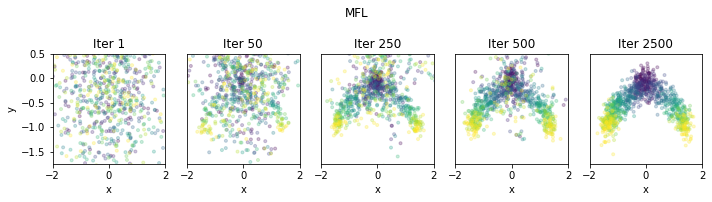

In [22]:
fig = plt.figure(figsize = (4*PLT_CELL, 1.125*PLT_CELL))
for (i, j) in enumerate(np.array([1, 50, 250, 500, 2500])-1):
    plt.subplot(1, 5, i+1)
    im = plt.scatter(output[2][j, :, :, :].reshape(-1, model_sim.dim)[:, 0], output[2][j, :, :, :].reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.linspace(0, model_sim.t_final, model_sim.T), np.ones(M)), alpha = 0.25, marker = ".")
    plt.ylim(-1.75, 0.5); plt.xlim(-2, 2)
    # plt.text(-1.75, -1.65, "Iter %d" % (j+1))
    plt.title("Iter %d" % (j+1))
    plt.xlabel("x")
    plt.ylabel("y")
    # if i // 4 == 0:
    #     plt.gca().get_xaxis().set_visible(False)
    if i % 5 > 0:
        plt.gca().get_yaxis().set_visible(False)
plt.suptitle("MFL")
plt.tight_layout()
plt.savefig("appendix_annealing_b_new.pdf")

# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
# cb = fig.colorbar(im, cax=cbar_ax)
# cb.set_alpha(1)
# cb.draw_all()
# cbar_ax.set_title("$t$")

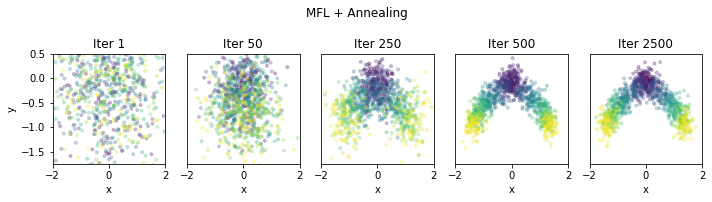

In [23]:
fig = plt.figure(figsize = (4*PLT_CELL, 1.125*PLT_CELL))
for (i, j) in enumerate(np.array([1, 50, 250, 500, 2500])-1):
    plt.subplot(1, 5, i+1)
    im = plt.scatter(output_anneal[2][j, :, :, :].reshape(-1, model_sim.dim)[:, 0], output_anneal[2][j, :, :, :].reshape(-1, model_sim.dim)[:, 1], c = np.kron(np.linspace(0, model_sim.t_final, model_sim.T), np.ones(M)), alpha = 0.25, marker = ".")
    plt.ylim(-1.75, 0.5); plt.xlim(-2, 2)
    # plt.text(-1.75, -1.65, "Iter %d" % (j+1))
    plt.title("Iter %d" % (j+1))
    plt.xlabel("x")
    plt.ylabel("y")
    # if i // 4 == 0:
    #     plt.gca().get_xaxis().set_visible(False)
    if i % 5 > 0:
        plt.gca().get_yaxis().set_visible(False)
plt.suptitle("MFL + Annealing")
plt.tight_layout()
plt.savefig("appendix_annealing_c_new.pdf")

# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.925, 0.15, 0.025, 0.7])
# cb = fig.colorbar(im, cax=cbar_ax)
# cb.set_alpha(1)
# cb.draw_all()
# cbar_ax.set_title("$t$")